In [1]:
import pandas as pd

In [2]:
import sys
sys.path.insert(0, "../")
from dataAnalysis.DataAnalysis import DataAnalysis
import pandas as pd
import torch
 
data = pd.read_csv(r"../sbcdata.csv", header=0)
data_analysis = DataAnalysis(data)

/home/dwalke/git/graph_aware_ml/time_series/../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']
/home/dwalke/git/graph_aware_ml/time_series/../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Label'] = self.data['Diagnosis']
/home/dwalke/git/graph_aware_ml/time_series/../dataAnalysis/data/Filter.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [3]:
data = pd.concat((data_analysis.get_training_data(), data_analysis.get_testing_data()))
max_Id = data["Id"].unique().max()
gw_data = data_analysis.get_gw_testing_data().copy(deep=True)
gw_data = gw_data.assign(Id=lambda x: x.Id + max_Id)
data = pd.concat((data, gw_data))
data = data.sort_values(["Id", "Time"])
data = data.reset_index(drop=True)
popped_index = data.pop("index")

In [4]:
train = (data["Center"] == "Leipzig") & (data["Set"] == "Training")
test = (data["Center"] == "Leipzig") & (data["Set"] == "Validation")
val = (data["Center"] == "Greifswald") & (data["Set"] == "Validation")

In [5]:
train = torch.from_numpy(train.values)
test = torch.from_numpy(test.values)
val = torch.from_numpy(val.values)

In [6]:
import torch
from dataAnalysis.Constants import SEX_CATEGORY_COLUMN_NAME, SEX_COLUMN_NAME, FEATURES, LABEL_COLUMN_NAME

data[SEX_CATEGORY_COLUMN_NAME] = data.loc[:, SEX_COLUMN_NAME] =="W"

data[SEX_CATEGORY_COLUMN_NAME] = data[SEX_CATEGORY_COLUMN_NAME].astype("int8")
data["Label"] = data["Label"] == "Sepsis"
data["Label"] = data["Label"].astype("int8")

X = data[FEATURES].values
y = data[LABEL_COLUMN_NAME].values

In [7]:
from sklearn.preprocessing import QuantileTransformer

scaler = QuantileTransformer(output_distribution="normal")
scaler.fit(X[train])
X = scaler.transform(X)

In [8]:
X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [9]:
id_grouped_data = data.groupby("Id")

In [10]:
import numpy as np
from tqdm.notebook import tqdm

edge_index_list = []
time_steps = 12

i = 0
for Id, group in tqdm(id_grouped_data):
    indices = group.index
    offset = indices[0]
    num_nodes = len(indices)
    indices = torch.from_numpy(indices.values)

    edge_indices = []
    for i in range(indices.shape[0]):
        sample_indices = indices[:i+1]
        padded_sample_indices = torch.nn.functional.pad(sample_indices, (time_steps - len(sample_indices), 0), mode='constant', value=sample_indices[0])
        edge_indices.append(padded_sample_indices.unsqueeze(0))
    edge_index_list.extend(edge_indices)

  0%|          | 0/866517 [00:00<?, ?it/s]

In [11]:
edge_index = torch.concat(edge_index_list, 0)

In [12]:
new_X_list = []
for i in range(edge_index.shape[0]):
    new_X_list.append(torch.index_select(X, 0, edge_index[i, :]).unsqueeze(0))

In [13]:
X_times = torch.concat(new_X_list, dim = 0)

In [14]:
device = torch.device("cuda:2") if torch.cuda.is_available() else torch.device("cpu")

y = y.to(device)
X_times = X_times.to(device)

In [15]:
X_times = X_times.type(torch.float32)
y = y.type(torch.float32)

In [16]:
train_idc = torch.where(train)[0]
new_train_idc = train_idc[:round(train_idc.shape[0]*.8)]
new_val_idc = train_idc[round(train_idc.shape[0]*.8):]
new_train = torch.zeros_like(train)
new_val = torch.zeros_like(train)
new_train[new_train_idc] = 1
new_val[new_val_idc] = 1
new_train = new_train.type(torch.bool)
new_val = new_val.type(torch.bool)

In [17]:
sets = dict()
sets["train"] = X_times[new_train]
sets["val"] = X_times[new_val]
sets["test"] =  X_times[test]
sets["gw_test"] =  X_times[val]

In [18]:
labels = dict()
labels["train"] = y[new_train]
labels["val"] = y[new_val]
labels["test"] =  y[test]
labels["gw_test"] =  y[val]

In [19]:
losses = dict()
losses["train"] = []
losses["val"] = []
losses["test"] = []
losses["gw_test"] = []

In [20]:
aurocs = dict()
aurocs["train"] = []
aurocs["val"] = []
aurocs["test"] = []
aurocs["gw_test"] = []

In [21]:
counts = torch.unique(y[train], return_counts=True)[-1]
WEIGHT = counts[0] / counts[-1]
WEIGHT

tensor(664.1861, device='cuda:2')

In [22]:
from sklearn.metrics import roc_auc_score

def evaluate(model, batch_loader, set_name):
    global X_times, losses, labels
    with torch.inference_mode():
        model.eval()
        acc_loss = 0
        batch_size = 0
        acc_labels = []
        acc_proba = []
        
        for x,y in batch_loader[set_name]:
            logits = model(x)
            last_logits_set = torch.squeeze(logits)
            loss = torch.nn.functional.binary_cross_entropy_with_logits(last_logits_set, y,pos_weight=WEIGHT)
            last_proba_set = torch.sigmoid(last_logits_set)
            acc_labels.extend(y.cpu().tolist())
            acc_proba.extend(last_proba_set.cpu().tolist())
            acc_loss += loss.item()
            batch_size+= x.shape[0]
        losses[set_name].append(acc_loss/batch_size)
        auroc = roc_auc_score(np.array(acc_labels), np.array(acc_proba))
        aurocs[set_name].append(auroc)
        # print(f"{set_name} has AUROC: {auroc}")

In [23]:
def full_batch_epoch(model, batch_loader):
    global X_times, y, sets
    model.train()
    optim.zero_grad()
    acc_loss = 0
    
    for x,y in batch_loader["train"]:
        logits = model(x)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(torch.squeeze(logits), y,pos_weight=WEIGHT)
        acc_loss+= loss.item()
        loss.backward()
    for set_name in sets:
        evaluate(model, batch_loader, set_name)
    optim.step()
    return acc_loss

In [24]:
from torch import nn
from torch.autograd import Variable 

class TimeTransformer(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size,dropout, layers, heads, dim_feedforward, project):
        super(TimeTransformer, self).__init__()
        self.num_classes = num_classes #number of classes
        self.input_size = input_size #input size
        self.hidden_size = hidden_size if project else input_size #hidden_size #hidden state
        self.num_layers = layers
        self.dropout = dropout
        self.project = project

        self.linear = nn.Linear(self.input_size, self.hidden_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=self.hidden_size, nhead=heads, dim_feedforward = dim_feedforward, dropout = self.dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=self.num_layers, enable_nested_tensor =True)
        self.fc_1 =  nn.Linear(self.hidden_size, 1) #fully connected 1

        self.relu = nn.ReLU()
    
    def forward(self,x):
        # Propagate input through LSTM
        if self.project:
            x = self.linear(x)
            x = self.relu(x)
        output = self.transformer(x)
        out = self.relu(output[:, -1, :])
        out = self.fc_1(out) #first Dense
        return out#output[:,-1,0] #out

In [25]:
def empty_dict(dictionary):
    for key in dictionary.keys():
        dictionary[key] = []

In [26]:
def transfer_dict(dictionary,device):
    for key in dictionary.keys():
        dictionary[key] = dictionary[key].to(device)

In [27]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

class Data(Dataset):
    # Constructor
    def __init__(self,X, y):
        self.x = X
        self.y = y
        self.len = self.x.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

In [28]:
batch_loader = dict()
batch_loader["train"] = []
batch_loader["val"] = []
batch_loader["test"] = []
batch_loader["gw_test"] = []

In [29]:
def add_loader(set_name):
    global bitch_loader, sets, labels
    dataset = Data(sets[set_name], labels[set_name])
    loader = DataLoader(dataset=dataset, batch_size=100_000) #max is 100_000
    batch_loader[set_name] = loader

In [30]:
for set_name in sets.keys():
    add_loader(set_name)

In [41]:
from tqdm.notebook import tqdm
import time

is_continue = True
if not is_continue:
    model = TimeTransformer(num_classes=1, input_size=X.shape[1],\
                            hidden_size=56, dropout=0.0,\
                            layers=2, heads=4, dim_feedforward=256, project=True).to(device) 
    
    transfer_dict(sets, device)
    transfer_dict(labels, device)
    empty_dict(losses)
    empty_dict(aurocs)
    lr = 0.01
    ## weight decay
    weight_decay = 1e-5
    optim = torch.optim.Adam(params=model.parameters(), lr = lr, weight_decay=weight_decay)

patience = 10
epochs = 60
for g in optim.param_groups:
    g['lr'] = 0.001
    
for epoch in tqdm(range(epochs)):
    print(epoch)
    start = time.time()
    loss = full_batch_epoch(model, batch_loader)
    if len(losses["val"]) > patience and all(list(map(lambda l: l<=losses["val"][-1], losses["val"][-patience-1:]))):
        break
    print(loss)

  0%|          | 0/60 [00:00<?, ?it/s]

0
6.843039453029633
1
6.830041080713272
2
6.804441213607788
3
6.7798503041267395
4
6.767058879137039
5
6.76564347743988
6
6.767154425382614
7
6.761890858411789
8
6.746504306793213
9
6.727755635976791
10
6.714290797710419
11
6.708358407020569
12
6.704869210720062
13
6.698262393474579
14
6.687606602907181
15
6.675382018089294
16
6.6647969186306
17
6.656890392303467
18
6.649917751550674
19
6.641197681427002
20
6.630573123693466
21
6.620122998952866
22
6.610578209161758
23
6.601296782493591
24
6.591876953840256
25
6.582182049751282
26


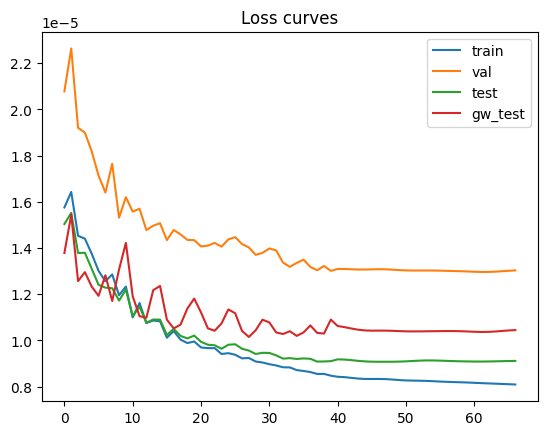

In [46]:
import matplotlib.pyplot as plt

for set_name in losses:
    plt.plot(losses[set_name])
plt.legend(losses.keys())
plt.title("Loss curves")
plt.show()

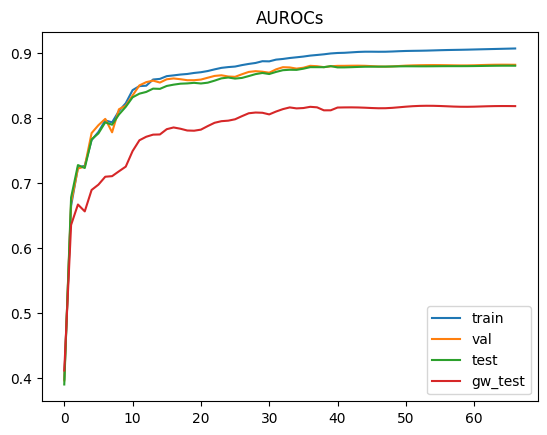

In [47]:
import matplotlib.pyplot as plt

for set_name in aurocs:
    plt.plot(aurocs[set_name])
plt.legend(aurocs.keys())
plt.title("AUROCs")
plt.show()

In [48]:
max(aurocs["test"])

0.8803431350287153

In [49]:
aurocs["test"][-1]

0.8802790864892954

## Evaluate the time series equence lengths

In [307]:
id_grouped_data.size().describe()

count    866517.000000
mean          2.099711
std           3.201005
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         416.000000
dtype: float64

In [312]:
num_sampples_list =  []
for i in range(id_grouped_data.size().max()+1):
    num_samples = (id_grouped_data.size() == i).sum()
    num_sampples_list.append(num_samples)

Text(0.5, 0, 'Length of time series')

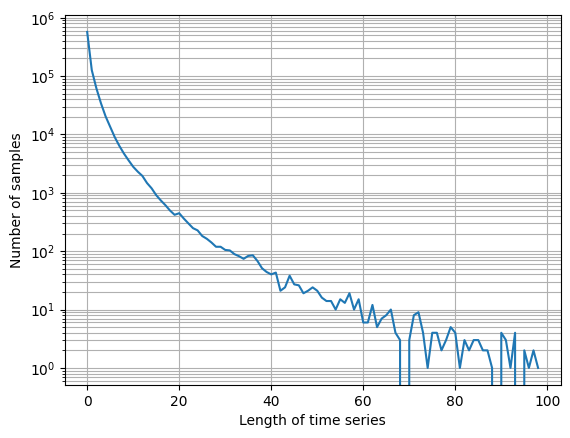

In [322]:
import matplotlib.pyplot as plt
plt.semilogy(num_sampples_list[1:100])
plt.grid(which="both")
plt.ylabel("Number of samples")
plt.xlabel("Length of time series")